In [1]:
import os 
import pickle
import hashlib

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

2024-09-18 12:46:34.779013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 12:46:34.876555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-18 12:46:34.876577: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-18 12:46:35.381115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/data/jcampos/projects/ml-quantum-readout/environment/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [49]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

## Setup data

In [50]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [4]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_location = 100
end_window = 500
window_size = 400

In [5]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_location*2:end_window*2]
y_train_val = one_hot_encode(y_train_val)
assert len(X_train_val[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(X_train_val):,}")
print(f"  Shape : {X_train_val[0].shape}")

Train Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_train_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_train_0_770.npy
  Size : 900,000
  Shape : (800,)


In [6]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_location*2:end_window*2]
y_test = one_hot_encode(y_test)
assert len(X_test[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(X_test):,}" )
print(f"  Sample Shape : {X_test[0].shape}")

Test Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_test_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_test_0_770.npy
  Size : 100,000
  Sample Shape : (800,)


## Build our model 
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [51]:
def get_model(input_shape, hidden=8, is_pruned=True):
    model = Sequential()
    model.add(QDense(
        hidden, 
        activation='relu', 
        name='fc1',
        input_shape=(input_shape,), 
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1)
    ))
    model.add(QBatchNormalization(
            name='batchnorm1',
            gamma_quantizer=quantized_bits(6, 0, 1),
            mean_quantizer=quantized_bits(6, 0, 1),
            variance_quantizer=quantized_bits(6, 0, 1),
            beta_quantizer=quantized_bits(6, 0, 1),
    ))
    model.add(
        QDense(2, name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1))
    )

    # adding pruning 
    if is_pruned == True:
        pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10, final_sparsity=0.50, begin_step=200, end_step=1000)}
        model = prune.prune_low_magnitude(model, **pruning_params)
    return model


input_shape = int((end_window-start_location)*2)
model = get_model(input_shape=input_shape)
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 8)                12810     
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_batchno  (None, 8)                33        
 rm1 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_fc2 (Pr  (None, 2)                36        
 uneLowMagnitude)                                                
                                                                 
Total params: 12,879
Trainable params: 6,442
Non-trainable params: 6,437
_________________________________________________________________
None


## Training 

In [52]:
init_learning_rate = 1e-2
validation_split = 0.05  # 45,000 sample size 
batch_size = 1024*8
epochs = 150
early_stopping_patience = 20
checkpoint_dir = '../checkpoints/scan_window_location_and_size_h8'
checkpoint_filename = 'qkeras_model_best.h5'

assert os.path.exists(checkpoint_dir), f'ERROR: Checkpoint directory {checkpoint_dir} does not exist.'

In [53]:
#########################
# 0. init callbacks
#########################
ckp_dir = os.path.join(checkpoint_dir, f'sl{start_location}_ws{window_size}')
if os.path.exists(ckp_dir) == False: os.mkdir(ckp_dir)
print('Saving to', ckp_dir)

ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
callbacks = [
    ModelCheckpoint(
        ckp_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        save_freq="epoch",
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=False,
    ),
    pruning_callbacks.UpdatePruningStep(),
    # ReduceLROnPlateau(patience=early_stopping_patience, min_delta=1**-6),
]


Saving to ../checkpoints/scan_window_location_and_size_h14/sl100_ws400


In [54]:
#########################
# 1. declare model 
#########################
opt = Adam(learning_rate=init_learning_rate)
model = get_model(input_shape=window_size*2)
model.compile(
    optimizer=opt, 
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

#########################
# 3. train 
#########################
history = model.fit(
    X_train_val, 
    y_train_val, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_split=validation_split, 
    shuffle=True, 
    callbacks=callbacks,
)

# Save the history dictionary
with open(os.path.join(ckp_dir, 'qkeras_training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

#########################
# 3. compute fidelity 
#########################
y_pred = model.predict(X_test)
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print('\n===================================')
print(f'Start location = {start_location}, Window size = {window_size}')
print('    Accuracy', test_acc)
print('    Fidelity', test_acc*2-1)


Epoch 1/150
105/105 [==============================] - 3s 16ms/step - loss: 0.2003 - accuracy: 0.9514 - val_loss: 0.1911 - val_accuracy: 0.9575
Epoch 2/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1727 - accuracy: 0.9604 - val_loss: 0.1773 - val_accuracy: 0.9582
Epoch 3/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1720 - accuracy: 0.9608 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 4/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1721 - accuracy: 0.9608 - val_loss: 0.1744 - val_accuracy: 0.9579
Epoch 5/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1721 - accuracy: 0.9608 - val_loss: 0.1743 - val_accuracy: 0.9581
Epoch 6/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1721 - accuracy: 0.9608 - val_loss: 0.1748 - val_accuracy: 0.9582
Epoch 7/150
105/105 [==============================] - 1s 12ms/step - loss: 0.1724 - accuracy: 0.9608 - val_loss: 0.1760 - val_accuracy:

## Check performance

In [55]:
checkpoint_filename = os.path.join(ckp_dir, checkpoint_filename)
checkpoint_filename

'../checkpoints/scan_window_location_and_size_h14/sl100_ws400/qkeras_model_best.h5'

In [56]:
# co = {}
# custom_objects={'PruneLowMagnitude':tfmot.sparsity.PruneLowMagnitude}
# _add_supported_quantized_objects(co)
# checkpoint_model = load_model(checkpoint_filename, custom_objects=co, compile=False)

checkpoint_model = get_model(input_shape=input_shape)
checkpoint_model.load_weights(checkpoint_filename)

y_pred = checkpoint_model.predict(X_test)
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print(f"Keras  Accuracy: {test_acc}")
print(f"Keras  Fidelity: {test_acc*2-1}")

checkpoint_model = strip_pruning(checkpoint_model)
checkpoint_model.save(checkpoint_filename)

3125/3125 [==============================] - 7s 2ms/step
Keras  Accuracy: 0.96069
Keras  Fidelity: 0.9213800000000001


## Check sparsity 

Number of layers: 3
% of zeros = 0.5
% of zeros = 0.0
% of zeros = 0.5


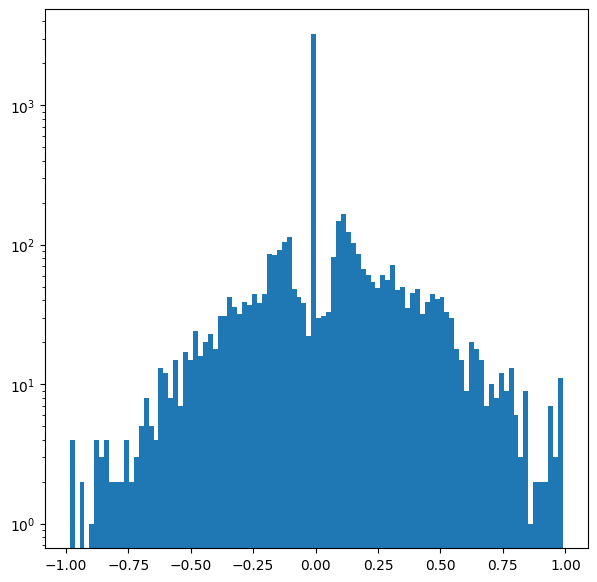

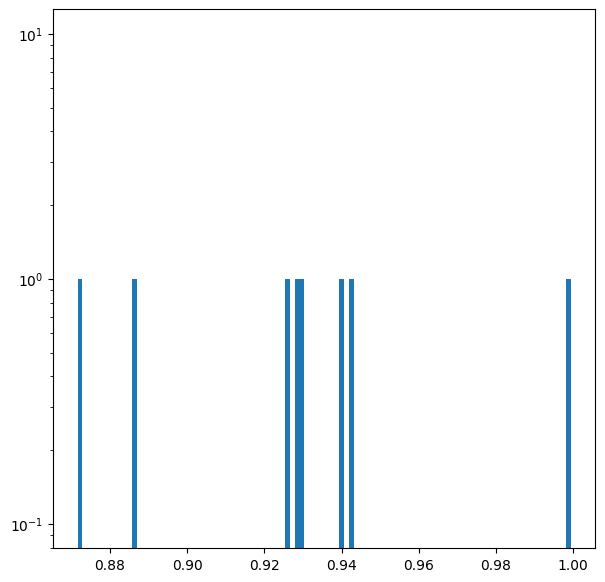

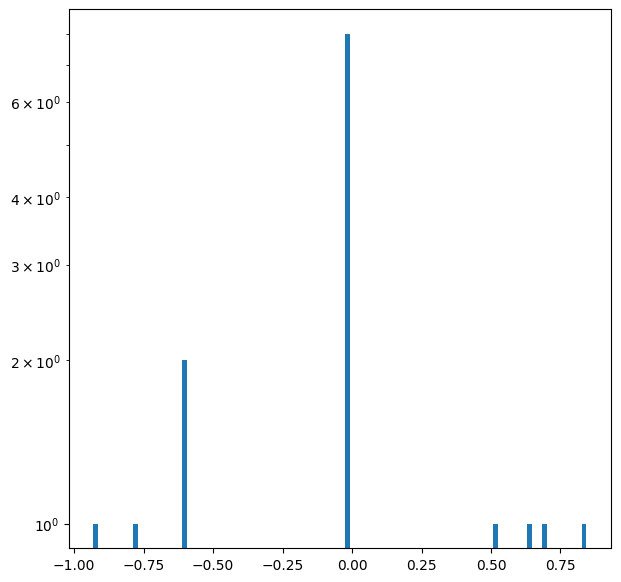

In [57]:
checkpoint_model = get_model(input_shape=input_shape, is_pruned=False)
checkpoint_model.load_weights(checkpoint_filename)

num_layers = len(checkpoint_model.layers)
print(f'Number of layers: {num_layers}')


for idx in range(num_layers):
    w = checkpoint_model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.savefig(f'model-dist-idx{idx}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## HLS4ML

In [58]:
import sys 
sys.path.append("../utils")
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [59]:
# Create HLS configuration 
hls_config = {}
hls_config['Model'] = {}
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
hls_config['Model']['ReuseFactor'] = 1  # fully parallelized 

hls_config['LayerName'] = {}
keras_layers = ['fc1', 'fc1_relu', 'batchnorm1', 'fc2', 'fc2_linear']
for layer in keras_layers:
    hls_config['LayerName'][layer] = {}
    hls_config['LayerName'][layer]['Precision'] = {}
    hls_config['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
hls_config['LayerName']['fc1_input'] = {}
hls_config['LayerName']['fc1_input']['Precision'] = {}
hls_config['LayerName']['fc1_input']['Trace'] = True
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc1
hls_config['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<17,17>'
hls_config['LayerName']['fc1']['accum_t'] = 'ap_fixed<17,17>'
# Fc1 relu
hls_config['LayerName']['fc1_relu']['Precision']['result'] = 'ap_fixed<17,17>'

# Batchnormalization
hls_config['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['accum_t'] = 'ap_fixed<24,4>'

# Fc2
hls_config['LayerName']['fc2']['Precision']['result'] = 'ap_fixed<8,5>'
hls_config['LayerName']['fc2']['accum_t'] = 'ap_fixed<8,5>'

# Fc2
hls_config['LayerName']['fc2_linear']['Precision']['result'] = 'ap_fixed<8,5>'

print_dict(hls_config)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1
    Precision
      result:        ap_fixed<17,17>
    Trace:           True
    accum_t:         ap_fixed<17,17>
  fc1_relu
    Precision
      result:        ap_fixed<17,17>
    Trace:           True
  batchnorm1
    Precision
      scale:         ap_fixed<24,4>
      bias:          ap_fixed<24,4>
      result:        ap_fixed<24,4>
    Trace:           True
    accum_t:         ap_fixed<24,4>
  fc2
    Precision
      result:        ap_fixed<8,5>
    Trace:           True
    accum_t:         ap_fixed<8,5>
  fc2_linear
    Precision
      result:        ap_fixed<8,5>
    Trace:           True
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True


### Build HLS model 

In [60]:
output_dir = f'../hls4ml_projects/sl-{start_location}_ws-{window_size}'
xilinx_part = 'xczu49dr-ffvf1760-2-e'
io_type = 'io_parallel'
clock_period = 3.225  # 3.225ns (307.2 MHz)
hls_fig = os.path.join(output_dir, 'model.png')
backend = 'VivadoAccelerator'
interface = 'axi_master'
driver = 'c'
board = 'zcu216'

In [61]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model=checkpoint_model,
    hls_config=hls_config,
    output_dir=output_dir,
    part=xilinx_part,
    io_type=io_type,
    clock_period=clock_period,
    backend=backend,
    board=board,
    interface=interface,
    driver=driver,
)

print(f"Creating hls4ml project directory {output_dir}")
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=hls_fig 
)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 8]
Layer name: batchnorm1, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: fc2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory ../hls4ml_projects/sl-100_ws-400
Writing HLS project


Done


## Check performance

In [62]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
y_hls = np.argmax(y_hls, axis=1)

keras_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
hls_acc = accuracy_score(np.argmax(y_test, axis=1), y_hls)

print(f'Keras Acc: {keras_acc*100:.5}%')
print(f'Keras Fidelity: {(keras_acc*2-1) * 100:.5}%')
print(f'HLS Acc: {hls_acc*100:.5}:%')
print(f'HLS Fidelity: {(hls_acc*2-1) * 100:.5}:%')

Keras Acc: 96.069%
Keras Fidelity: 92.138%
HLS Acc: 95.322:%
HLS Fidelity: 90.644:%


## Correlation plots (Keras vs HLS)
Let's compare the output of the Qkeras and HLS model. If properly configured, the HLS activations will be aligned with the Qkeras model. 

In [63]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(checkpoint_model, X_test) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling myproject with tracing
Writing HLS project


Done
3125/3125 [==============================] - 7s 2ms/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1', 'fc1_relu', 'batchnorm1', 'fc2'])
Keras Keys: dict_keys(['fc1', 'fc1_relu', 'batchnorm1', 'fc2'])


Layer(s): fc1 		 180.77695
hls/keras min: -58119.0/-57952.375
hls/keras max: 60864.0/61038.59375
Layer(s): fc1_relu 		 92.82321
hls/keras min: 0.0/0.0
hls/keras max: 60864.0/61038.59375
Layer(s): batchnorm1 		 0.8381822
hls/keras min: -1.0823593139648438/-0.25010451674461365
hls/keras max: 4.688243865966797/5.808126926422119
Layer(s): fc2 		 0.47903883


hls/keras min: -6.9375/-7.593348503112793
hls/keras max: 5.625/6.295644760131836


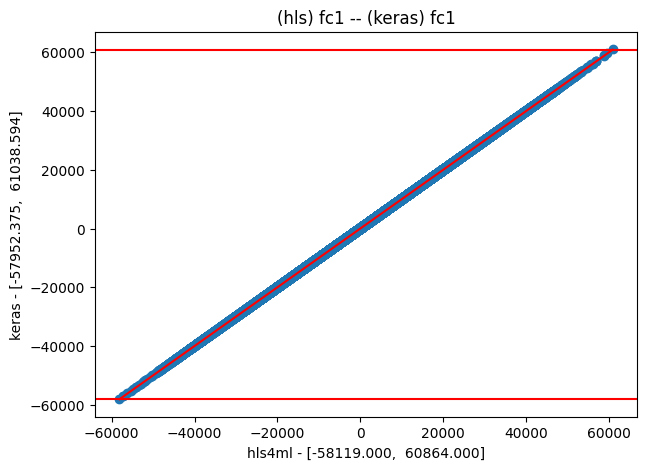

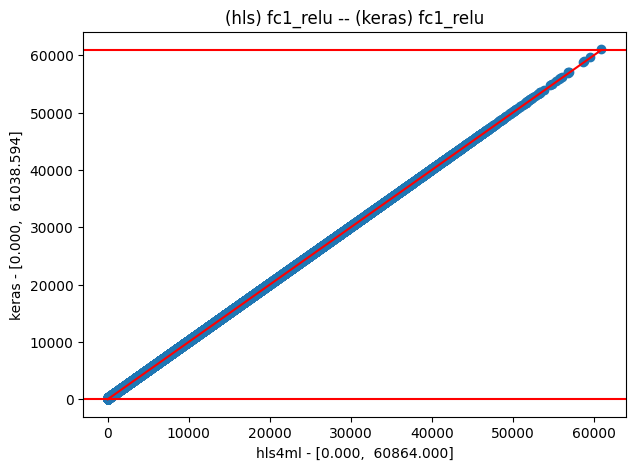

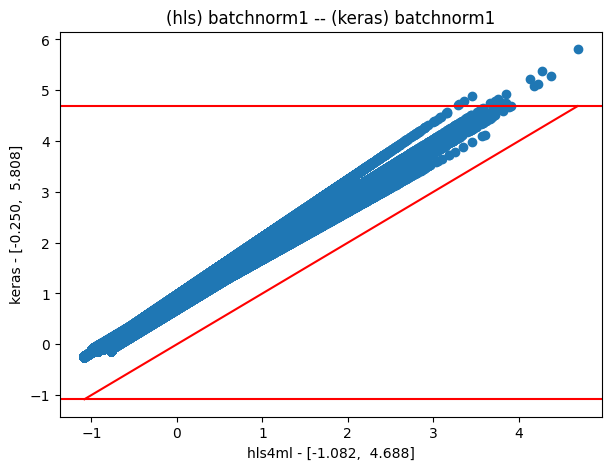

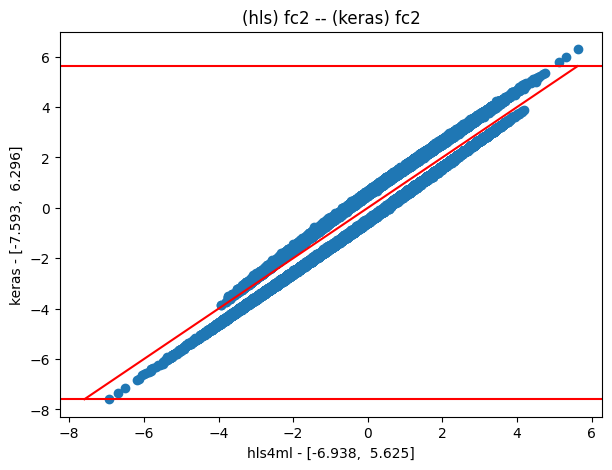

In [64]:
idx = 0

hls_layers = hls_trace.keys()
keras_layers = list(keras_trace.keys())
# keras_layers = ['q_dense_1', 'q_batch_normalization_1', 'fc2']

for hls_layer, keras_layer in zip(hls_layers, keras_layers):
    keras_layer, hls_layer = keras_trace[keras_layer], hls_trace[hls_layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'Layer(s): {list(hls_trace.keys())[idx]}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {list(hls_trace.keys())[idx]} -- (keras) {list(keras_trace.keys())[idx]}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
        idx += 1
    except Exception as e:
        print(e)


## Synthesize 

In [ ]:
hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=False,
    vsynth=True,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jcampos' on host 'correlator4.fnal.gov' (Linux_x86_64 version 5.14.0-427.33.1.el9_4.x86_64) on Mon Sep 16 23:00:57 CDT 2024
INFO: [HLS 200-10] On os "AlmaLinux release 9.4 (Shamrock Pampas Cat)"
INFO: [HLS 200-10] In directory '/data/jcampos/projects/ml-quantum-readout/hls4ml_projects/sl-100_ws-450'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/data/jcampos/projects/ml-quantum-readout/hls4ml_projects/sl-100_ws-450/myproject_prj'.
INFO: [HLS 200-10] Adding design file 

{}

## Check the report

In [ ]:
hls4ml.report.read_vivado_report(output_dir)

Path hls4ml_prj//hls4ml_prj does not exist. Exiting.
